# Hi :)

----

# Import libraries

In [1]:
import numpy as np
from numpy.linalg import inv
import pandas as pd
import matplotlib.pyplot as plt

# Initialization

In [2]:
# Physical parameters
m= 0.1    # pendulum mass (kg)
M= 5.0    # cart mass (kg)
g= 9.81   # gravity (m/s^2)
l= 0.72   # pendulum length (m)
dt= 0.001 # sampling time (s) = 1ms

# Continuous-time dynamics
def pendulum_dynamics(x, u):
    x1, x2, x3, x4= x

    dx1= x2

    num2= u * np.cos(x1) - (M + m) * g * np.sin(x1) + m * l * np.cos(x1) * np.sin(x1) * x2**2
    den2= m * l * np.cos(x1)**2 - (M + m) * l
    dx2= num2 / den2

    dx3= x4

    num4= u + m * l * np.sin(x1) * x2**2 - m * g * np.cos(x1) * np.sin(x1)
    den4= M + m - m * np.cos(x1)**2
    dx4= num4 / den4

    return np.array([dx1, dx2, dx3, dx4])

# Discretization

In [3]:
# Discretization using Euler integration
def discrete_step(x, u, dt):
    dx= pendulum_dynamics(x, u)
    return x + dt * dx

In [4]:
# Initial state and zero input
x0= np.array([0.0, 0.0, 0.0, 0.0])
u= 0

In [5]:
# Simulate for 100 steps
x= x0
states= [x0]
for _ in range(100):
    x= discrete_step(x, u, dt)
    states.append(x)

states= np.array(states)

Visualization

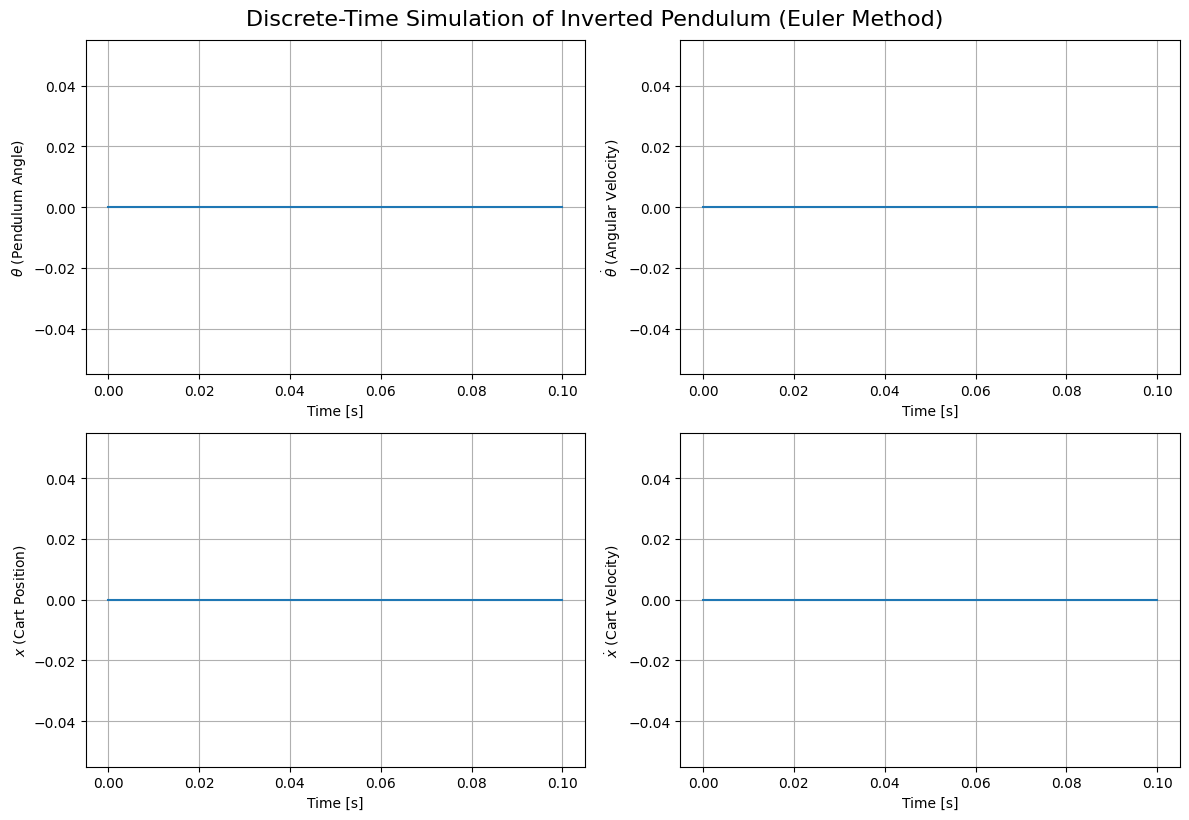

In [6]:
# Time vector
time= np.arange(states.shape[0]) * dt

# Plotting
plt.figure(figsize=(12, 8))

labels= [r'$\theta$ (Pendulum Angle)', 
          r'$\dot{\theta}$ (Angular Velocity)', 
          r'$x$ (Cart Position)', 
          r'$\dot{x}$ (Cart Velocity)']

for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.plot(time, states[ : , i])
    plt.xlabel('Time [s]')
    plt.ylabel(labels[i])
    plt.grid(True)

plt.tight_layout()
plt.suptitle('Discrete-Time Simulation of Inverted Pendulum (Euler Method)', fontsize= 16, y= 1.02)
plt.show()

# Making the noisy dataset

Initialization

In [7]:
# Random seed for reproducibility
np.random.seed(48)

# Constants
T= 10.0  # total simulation time in seconds
dt= 0.001
N= int(T / dt) + 1  # number of time steps

# Initial state from uniform distribution
x0= np.random.uniform(-0.1, 0.1, size= 4)

# Process and measurement noise covariance
Q= np.array([
    [15.0, 0, 0, 0],
    [0, 9.6, 0, 0],
    [0, 0, 10.0, 0],
    [0, 0, 0, 17.0]
])
R= np.array([
    [19.2, 0],
    [0, 16.8]
])

# Prameters setup for simulation
u= 0.0

# Warning!

You can skip cells below till the next seperate line if you already have the "pendulum_noisy_data.xlsx" file.

----

Simulation

In [8]:
# Simulate with process and measurement noise
states= np.zeros((N, 4))
measurements= np.zeros((N, 2))
x= x0.copy()

for t in range(N):
    # Save state
    states[t]= x
    # Generate measurement (y1 = x1, y2 = x3)
    y= np.array([x[0], x[2]]) + np.random.multivariate_normal(np.zeros(2), R)
    measurements[t]= y
    # Apply dynamics + process noise
    x= discrete_step(x, u, dt) + np.random.multivariate_normal(np.zeros(4), Q)

# Simulation
df_states= pd.DataFrame(states, columns=['x1', 'x2', 'x3', 'x4'])
df_measurements= pd.DataFrame(measurements, columns= ['y1', 'y2'])
df= pd.concat([df_states, df_measurements], axis= 1)
df.head()

,x1,x2,x3,x4,y1,y2
0,-0.096502,0.078315,-0.043028,-0.040205,-2.892411,4.308191
1,4.139569,2.247808,-6.604332,-0.689180,11.477467,-8.232918
2,0.269992,-3.971172,-8.373199,8.891932,-1.333998,-13.522470
3,2.571565,1.751338,-3.434971,17.306869,-2.288290,-9.727630
4,-0.948620,0.314196,-2.214273,24.142718,-0.488177,-3.967612


In [9]:
# Saving to Excel
df.to_excel('pendulum_noisy_data.xlsx', index= False)

Visualization

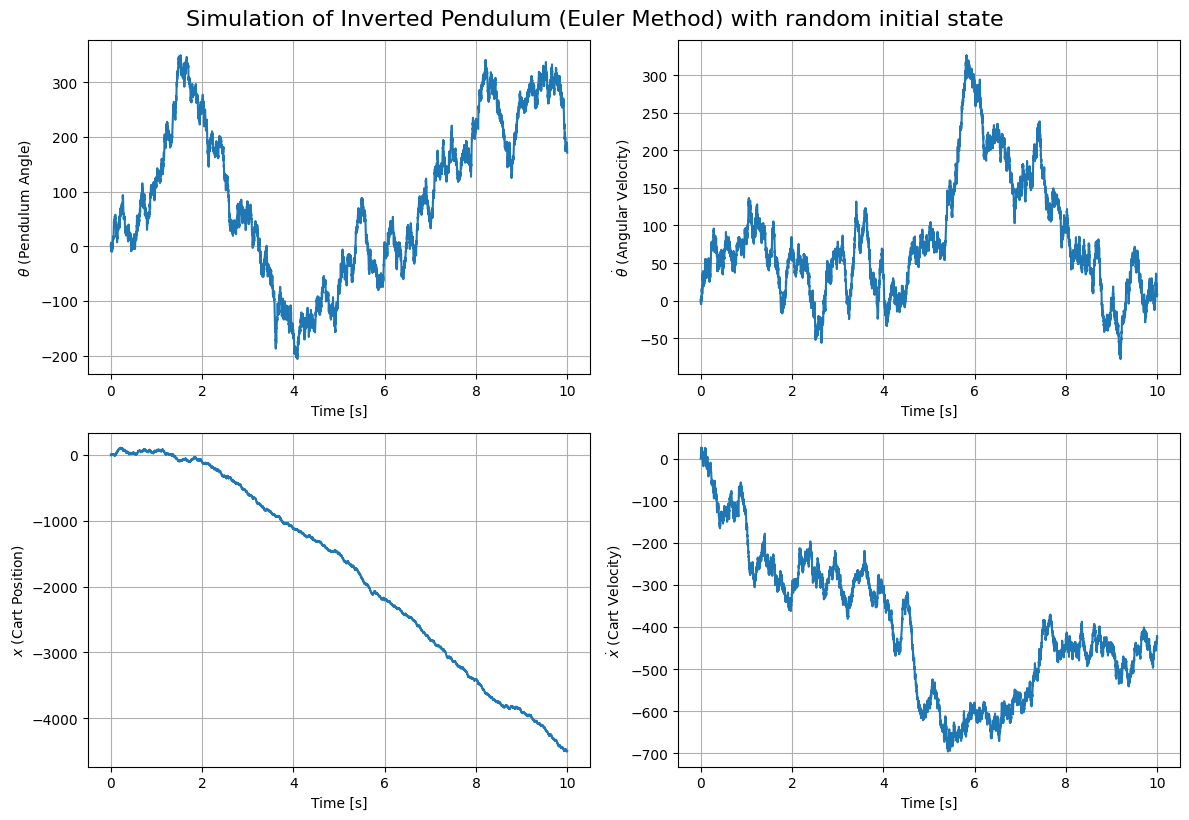

In [10]:
# Time vector
time= np.arange(states.shape[0]) * dt

# Plotting
plt.figure(figsize=(12, 8))

labels= [r'$\theta$ (Pendulum Angle)', 
          r'$\dot{\theta}$ (Angular Velocity)', 
          r'$x$ (Cart Position)', 
          r'$\dot{x}$ (Cart Velocity)']

for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.plot(time, states[ : , i])
    plt.xlabel('Time [s]')
    plt.ylabel(labels[i])
    plt.grid(True)

plt.tight_layout()
plt.suptitle('Simulation of Inverted Pendulum (Euler Method) with random initial state', fontsize= 16, y= 1.02)
plt.show()

----

# EKF & UKF & PF

Loading the data

In [11]:
# Load data
data= pd.read_excel('pendulum_noisy_data.xlsx')

# Extract true states and measurements
X_true= data[['x1', 'x2', 'x3', 'x4']].values
Y_meas= data[['y1', 'y2']].values

In [12]:
# Constants
dt= 0.001
steps= X_true.shape[0]

# EKF

Manual implementation

Initialization

In [13]:
# --- System dynamics (as before) ---
def f(x, u= 0):
    return discrete_step(x, u, dt)

# --- Measurement model ---
def h(x):
    return np.array([x[0], x[2]])

# --- Jacobians using finite difference ---
def jacobian_f(x, eps= 1e-5):
    n= len(x)
    F= np.zeros((n, n))
    fx= f(x)
    for i in range(n):
        dx= np.zeros(n)
        dx[i] = eps
        F[:, i]= (f(x + dx) - fx) / eps
    return F

def jacobian_h(x):
    H= np.zeros((2, 4))
    H[0, 0]= 1
    H[1, 2]= 1
    return H

# Initial state guess and covariance
x_est= np.zeros(4)
P= np.eye(4) * 1.0

# Noise covariances
Q_ekf= Q
R_ekf= R

EKF loop

In [14]:
# Store results
X_ekf= np.zeros_like(X_true)

for k in range(steps):
    # Prediction
    F_k= jacobian_f(x_est)
    x_pred= f(x_est)
    P_pred= F_k @ P @ F_k.T + Q_ekf

    # Update
    H_k= jacobian_h(x_pred)
    y_pred= h(x_pred)
    y= Y_meas[k]
    S= H_k @ P_pred @ H_k.T + R_ekf
    K= P_pred @ H_k.T @ inv(S)

    x_est= x_pred + K @ (y - y_pred)
    P= (np.eye(4) - K @ H_k) @ P_pred

    # Store estimate
    X_ekf[k]= x_est

RMSE

In [15]:
rmse_ekf= np.sqrt(np.mean((X_true - X_ekf)**2, axis= 0))
print("EKF RMSE for each state:", rmse_ekf)

EKF RMSE for each state: [  3.35942272 115.22321828   3.00195536 137.09247471]


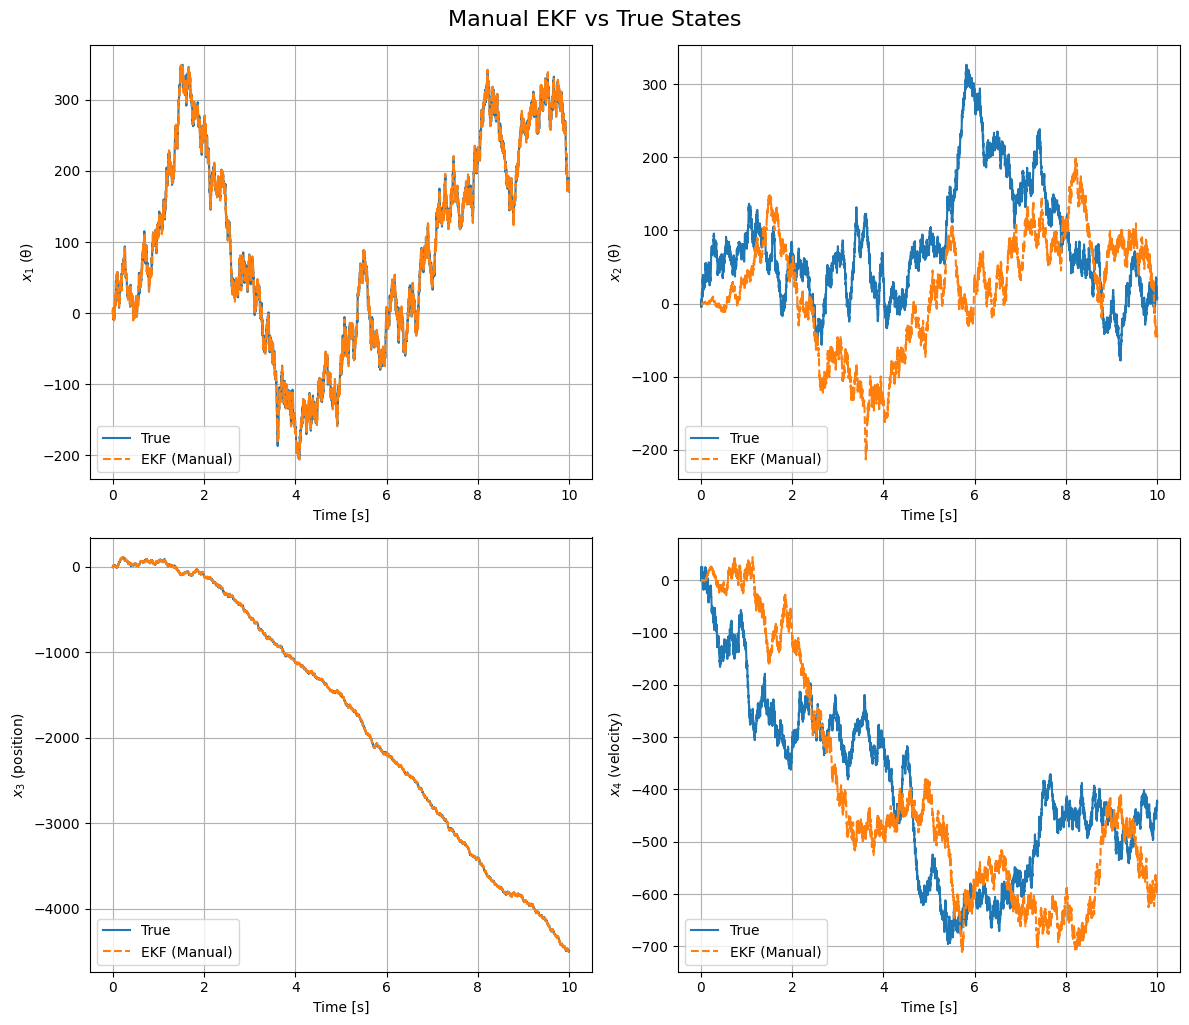

In [16]:
time= np.arange(steps) * dt
labels= [r'$x_1$ (θ)', r'$x_2$ (θ̇)', r'$x_3$ (position)', r'$x_4$ (velocity)']

plt.figure(figsize= (12, 10))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.plot(time, X_true[:, i], label= 'True', linewidth= 1.5)
    plt.plot(time, X_ekf[:, i], label= 'EKF (Manual)', linestyle= '--')
    plt.xlabel('Time [s]')
    plt.ylabel(labels[i])
    plt.grid(True)
    plt.legend(loc= 3)

plt.tight_layout()
plt.suptitle('Manual EKF vs True States', fontsize= 16, y= 1.02)
plt.show()